## CS203 Assignment 11

## Software Tools and Techniques for AI

- Chinmay Pendse (23110245)
- Dakshata Bhamare (23210027)


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os

In [2]:
train_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
test_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"

# Load data with header row
train_df = pd.read_csv(train_url, sep="\t")   # will automatically use header
test_df = pd.read_csv(test_url, sep="\t")


In [3]:
print(train_df.columns)
print(test_df.columns)


Index(['a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films', '1'], dtype='object')
Index(['no movement , no yuks , not much of anything', '0'], dtype='object')


In [4]:
train_df = pd.read_csv(train_url, sep="\t", header=None, names=["sentence", "label"])
test_df = pd.read_csv(test_url, sep="\t", header=None, names=["sentence"])

In [ ]:
print(train_df.head())
print(test_df.head())


                                            sentence  label
0  a stirring , funny and finally transporting re...      1
1  apparently reassembled from the cutting room f...      0
2  they presume their audience wo n't sit still f...      0
3  this is a visually stunning rumination on love...      1
4  jonathan parker 's bartleby should have been t...      1
                                                    sentence
no movement , no yuks , not much of anything               0
a gob of drivel so sickly sweet , even the eage...         0
gangs of new york is an unapologetic mess , who...         0
we never really feel involved with the story , ...         0
this is one of polanski 's best films                      1


In [5]:
# Convert the 'sentence' column in test_df to string type
test_df['sentence'] = test_df['sentence'].astype(str)

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(train_df['sentence']).toarray()
X_test = vectorizer.transform(test_df['sentence']).toarray() # This should now work without error

# Labels
y = train_df['label'].values

# Split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Final print to verify shapes
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (5536, 5000)
Validation data shape: (1384, 5000)
Test data shape: (1821, 5000)


In [6]:
# Create PyTorch datasets and dataloaders
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [7]:
#defining MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]), nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]), nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]), nn.ReLU(),
            nn.Linear(hidden_sizes[2], hidden_sizes[3]), nn.ReLU(),
            nn.Linear(hidden_sizes[3], output_size)
        )

    def forward(self, x):
        return self.model(x)

input_size = 5000
hidden_sizes = [512, 256, 128, 64]
output_size = 2

model = MLP(input_size, hidden_sizes, output_size)

# this fucntions helps counting the number of  trainable parmetrs
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {count_parameters(model)}")

Trainable Parameters: 2733122


In [9]:
model.eval()

MLP(
  (model): Sequential(
    (0): Linear(in_features=5000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [10]:
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch 1: Train Loss=0.6051, Val Loss=0.4660, Val Acc=77.82%
Epoch 2: Train Loss=0.3026, Val Loss=0.4478, Val Acc=78.47%
Epoch 3: Train Loss=0.1332, Val Loss=0.6262, Val Acc=78.32%
Epoch 4: Train Loss=0.0334, Val Loss=1.0482, Val Acc=77.24%
Epoch 5: Train Loss=0.0068, Val Loss=1.4527, Val Acc=78.83%
Epoch 6: Train Loss=0.0016, Val Loss=1.8915, Val Acc=78.32%
Epoch 7: Train Loss=0.0019, Val Loss=1.8030, Val Acc=78.83%
Epoch 8: Train Loss=0.0012, Val Loss=1.8785, Val Acc=78.83%
Epoch 9: Train Loss=0.0010, Val Loss=1.9587, Val Acc=78.83%
Epoch 10: Train Loss=0.0009, Val Loss=2.2775, Val Acc=77.31%


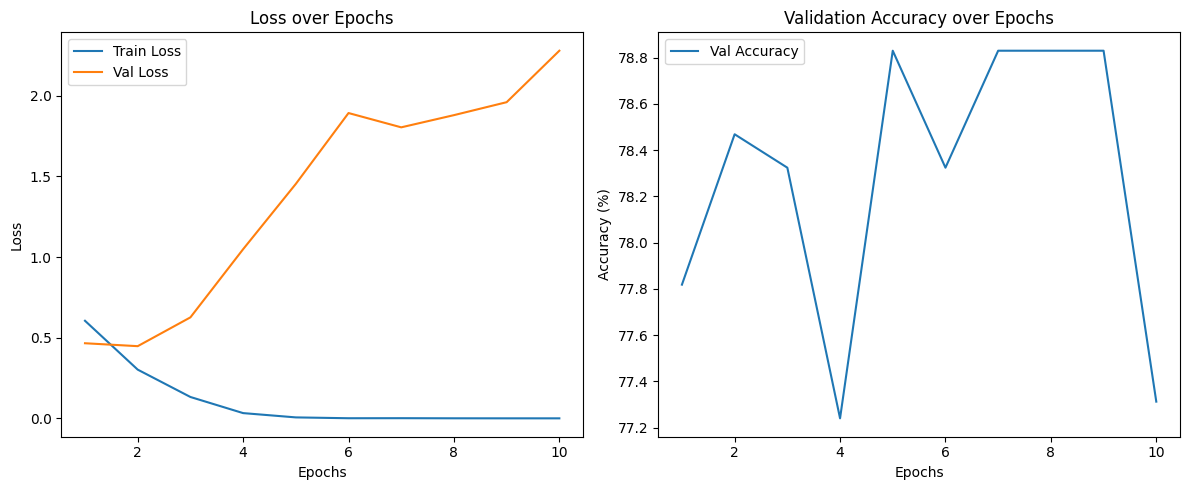

In [11]:
# Training the model
best_val_acc = 0.0
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, Val Acc={val_acc:.2f}%")

    # this saves the best checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'checkpoint.pt')

# pltig  validation accuracy and loss
epochs = range(1, 11)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
model = MLP(input_size, hidden_sizes, output_size)
model.load_state_dict(torch.load("checkpoint.pt"))
model.eval()

MLP(
  (model): Sequential(
    (0): Linear(in_features=5000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [13]:
# defining a dynamic model
model_dynamic = torch.quantization.quantize_dynamic(
    model, {nn.Linear}, dtype=torch.qint8
)

# defining a Half Precision model
model_half = MLP(input_size=5000, hidden_sizes=[512, 256, 128, 64], output_size=2).to(device)
model_half.load_state_dict(torch.load("checkpoint.pt"))
model_half = model_half.half()  #casting float16

In [14]:
# checking the type of model parameters
for param in model.parameters():
    print(param.dtype)
    break

torch.float32


Defining some functions to compare

In [15]:
def measure_inference_time(model, loader, use_half=False, use_dynamic=False):
    model.eval()

    if use_dynamic:
        device_eval = torch.device("cpu")
        model.to(device_eval)
    else:
        device_eval = device
        model.to(device_eval)
        if use_half:
            model = model.half()

    total_time = 0
    total_samples = 0

    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, dict):
                X_batch = batch['input']
            else:
                X_batch, _ = batch
            X_batch = X_batch.to(device_eval)
            if use_half:
                X_batch = X_batch.half()

            start = time.time()
            _ = model(X_batch)
            end = time.time()

            total_time += (end - start)
            total_samples += X_batch.size(0)

    avg_time_ms = (total_time / total_samples) * 1000
    return avg_time_ms



original_inference_time = measure_inference_time(model, val_loader)
dynamic_inference_time = measure_inference_time(model_dynamic, val_loader, use_dynamic=True)
half_inference_time = measure_inference_time(model_half, val_loader, use_half=True)



In [16]:
# Accuracy
def evaluate_accuracy(model, loader, use_half=False, use_dynamic=False):
    model.eval()

    # Handle dynamic quantized models on CPU
    if use_dynamic:
        device_eval = torch.device("cpu")
        model.to(device_eval)
    else:
        device_eval = device
        model.to(device_eval)
        if use_half:
            model = model.half()

    correct, total = 0, 0
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, dict):
                X_batch = batch['input']
                y_batch = batch['label']
            else:
                X_batch, y_batch = batch

            X_batch, y_batch = X_batch.to(device_eval), y_batch.to(device_eval)
            if use_half:
                X_batch = X_batch.half()

            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    return 100 * correct / total


original_accuracy = evaluate_accuracy(model, val_loader)
dynamic_accuracy = evaluate_accuracy(model_dynamic, val_loader, use_dynamic=True)
half_accuracy = evaluate_accuracy(model_half, val_loader, use_half=True)


In [17]:
import os

def get_model_size(path):
    return os.path.getsize(path) / (1024 * 1024)  # Size in MB

torch.save(model.state_dict(), "original_model.pt")
torch.save(model_dynamic.state_dict(), "dynamic_model.pt")
torch.save(model_half.state_dict(), "half_model.pt")

original_size = get_model_size("original_model.pt")
dynamic_size = get_model_size("dynamic_model.pt")
half_size = get_model_size("half_model.pt")

print("| S.I. | Model    | Accuracy (%) | Storage (MB) | Inference Time (ms) |")
print("|------|----------|--------------|---------------|----------------------|")
print(f"| 1    | Original | {original_accuracy:.2f}       | {original_size:.2f} MB      | {original_inference_time:.2f} ms         |")
print(f"| 2    | Dynamic  | {dynamic_accuracy:.2f}       | {dynamic_size:.2f} MB      | {dynamic_inference_time:.2f} ms         |")
print(f"| 3    | Half     | {half_accuracy:.2f}       | {half_size:.2f} MB      | {half_inference_time:.2f} ms         |")


| S.I. | Model    | Accuracy (%) | Storage (MB) | Inference Time (ms) |
|------|----------|--------------|---------------|----------------------|
| 1    | Original | 78.83       | 10.43 MB      | 0.01 ms         |
| 2    | Dynamic  | 78.83       | 2.62 MB      | 0.08 ms         |
| 3    | Half     | 78.83       | 5.22 MB      | 0.10 ms         |


## End of Assignment. Thank You